# **Introduction**

### **Task**
In this homework, the task is to implement the stages of finding textually similar documents based on Jaccard similarity using the shingling, minhashing, and locality-sensitive hashing (LSH) techniques and corresponding algorithms.

### **Code structure**
We used a collections of classes :

* A class **Shingler** that constructs k–shingles of a given length k (e.g., 5) from a given text (str) and computes a hash value for each unique shingle and represents the document in the form of a set of its hashed k-shingles.
* A class **Comparer** that computes the Jaccard similarity of two sets of shingles or similarity between 2 signatures.
* A class **MinHasher** that builds a minHash signature in the form of a vector (list or array) of a given length *signature_length* from a given set of integers (a set of hashed shingles).
* A class **LSH_computer** that implements the LSH technique: given a collection of minhash signatures (signature matrix) and a band number, the LSH class (using banding and hashing) finds candidate pairs of signatures agreeing on at least a fraction s=(1/b)^(1/r) of their components



## **Imports**

In [ ]:
from hashlib import blake2b
import numpy as np
from itertools import combinations
import os
from tqdm.auto import tqdm
import time

## **Shingling class**

In [ ]:
class Shingler:
    def __init__(self) -> None:
        pass

    def shingle_list(self, text, k):
        """Fct that divises the text into a set of k-shingles and hashes every shingles into a 4 bytes integer

        :returns: list of shingles of the text
        :rtype: list of int
        """
        # Create a bag of k-shingles from the text
        shingles_list = [text[idx:idx + k] for idx in range(0, len(text)-k+1)]
        # Remove depulicates to create a set of shingles
        shingles_list = list(set(shingles_list)) 
        # Hash the shingles
        for i, elt in enumerate(shingles_list):
            shingles_list[i] = int.from_bytes(blake2b(bytes(elt, "utf-8"), digest_size=4).digest(), "little")
        shingles_list.sort()

        return shingles_list
    
    def shingle_list_bytes(self, text, k):
        """Fct that divises the text into a set of k-shingles and hashes every shingles into a 4 bytes hexadecimal integer

        :returns: list of shingles of the text
        :rtype: list of bytes
        """
        # Create a bag of k-shingles from the text
        shingles_list = [text[idx:idx + k] for idx in range(0, len(text)-k+1)]
        # Remove depulicates to create a set of shingles
        shingles_list = list(set(shingles_list)) 
        # Hash teh shingles
        for i, elt in enumerate(shingles_list):
            shingles_list[i] = blake2b(bytes(elt, "utf-8"), digest_size=4).digest()

        return shingles_list

## **Compare Sets class**

In [ ]:
class Comparer:
    def __init__(self) -> None:
        pass
    
    def jaccard_similarity(self, set1, set2) -> float:
        """Compute the jaccard similarity bewtween the 2 sets (set1 & set2)

        :param set1: First set of shingles
        :type set1: list
        :param set2: Second set of shingles
        :type set2: list

        :returns: jaccard similarity between the 2 sets
        :rtype: float
        """
        if type(set1) == list:
          s1 = set(set1)
          s2 = set(set2)
          return len(s1.intersection(s2)) / len(s1.union(s2))
        elif type(set1) == set:
          return len(s1.intersection(s2)) / len(s1.union(s2))
        else:  # old naïve version
          union_length = len(list(set(set1 + set2)))
          intersection_counter = 0
          for shingle in set1:
              if shingle in set2:
                  intersection_counter += 1
          return intersection_counter/union_length
    
    def similar(self, set1, set2, similarity_threshold):
        """Tells if the 2 sets (set1 & set2) are similar (according to jaccard similarity) regarding the similarity threshold

        :param set1: First set of shingles
        :type set1: list
        :param set2: Second set of shingles
        :type set2: list
        :param similarity_threshold: threshold
        :type similarity_threshold: float

        :returns: True or False and jaccard similarity between the 2 sets
        :rtype: float
        """

        similarity = self.jaccard_similarity(set1, set2)
        if similarity >= similarity_threshold:
            return True, similarity
        else:
            return False, similarity
          
    def similar_signature(self, signature1, signature2, similarity_threshold):
        """Tells if the 2 signatures (signature1 & signature2) are similar regarding the similarity threshold

        :param signature1: First signature
        :type signature1: nd.array or a list
        :param signature2: Second signature
        :type signature2: nd.array or a list
        :param similarity_threshold: threshold
        :type similarity_threshold: float

        :returns: True or False and similarity between the 2 signatures
        :rtype: float
        """
        similarity = sum(signature1 == signature2)/len(signature1)
        if similarity >= similarity_threshold:
            return True, similarity
        else:
            return False, similarity
    
    def signature_similarity(self, signature1, signature2):
        return sum(signature1 == signature2)/len(signature1)

## **MinHashing class**

In [ ]:
class MinHasher:
    def __init__(self) -> None:
        pass
    
    def compute_minhash(self, set, signature_length, r_type="list", seed=None):
        """Compute the minHash of set. The minHash will have a length of signature_length

        :param set: Length of the minHash
        :type set: list
        :param signature_length: Length of the minHash
        :type signature_length: int
        :param r_type: Type returned list or array
        :type r_type: str
        :param seed: Seed for the np.random module (default=None -> will not be used)
        :type seed: int

        :returns: minHash also called signature of the set
        :rtype: list
        """

        # If a seed is passed the seed will be initialized
        if seed is not None:
            np.random.seed(seed)
        # Generate a list signature_length salt to design signature_length different hash functions
        salt_list = np.random.randint(0, 2**16, size=signature_length)
        int_type = int
        bytes_type = bytes
        set_type = type(set[0])

        signature = []
        # Compute the minimum hash for every hash function to get the signature (=minHash) of the set of int
        if set_type == int_type:
            for i in range(signature_length):
                hashed_set = []
                for _, elt in enumerate(set):
                    hashed_set.append(int.from_bytes(blake2b(elt.to_bytes(4, "little"), digest_size=4, salt=salt_list[i]).digest(), "little"))
                signature.append(min(hashed_set))
        
        # For set of bytes instead of int
        elif set_type == bytes_type:
            for i in range(signature_length):
                hashed_set = []
                for _, elt in enumerate(set):
                    hashed_set.append(int.from_bytes(blake2b(elt, digest_size=4, salt=salt_list[i]).digest(), "little"))
                signature.append(min(hashed_set))

        # set_type should not take any other value type
        else:
            raise ValueError("The type of set can not be handled ! -> Verify the set")
        
        # Returns the minHash (=signature) in the desired type
        if r_type == "list":
            return signature
        elif r_type == "array":
            return np.reshape(np.array(signature), (signature_length, 1))
        else:
            raise ValueError("The return type can not be handled ! -> Change the return type")


## **LSH class**

In [ ]:
class LSH_computer:
    def __init__(self) -> None:
        pass

    def find_possible_pairs(self, signature_matrix, band_number) -> list:
        """Find the pairs of signature that can be evaluated

        :param signature_matrix: Matrix which contains signatures of several documents
        :type signature_length: np.array
        :param band_number: Number of band in which the signature_matrix should be divided
        :type signature_length: int

        :returns: list of pairs which should be evaluated
        :rtype: list
        """
        
        n, p = signature_matrix.shape
        rows_per_band = int(np.floor(n/band_number))
        pairs_list = []

        print(f"\nLSH is to computed for an approximate similarity threshold t={round(((1/band_number)**(1/rows_per_band))*100, 2)}%")

        for i in range(band_number):
            buckets = {} # Different buckets for each band
            for c in range(p):
                # Compute the correct ending row
                if i < band_number-1:
                    ending_row = (i+1) * rows_per_band
                else:
                    ending_row = n  # last band has a size of : rows_per_band + n % band_number
                
                # Compute the hash of the i-th part of the c-th signature
                hash = blake2b(bytes("".join(map(str, signature_matrix[i*rows_per_band:ending_row, c])), "utf-8"), digest_size=4).digest()
                
                # Add the signature to the corresponding bucket (creating it if it does not exist)
                if hash not in buckets:
                    buckets[hash] = [c]
                else:
                    buckets[hash].append(c)
                    pairs_list += list(combinations(buckets[hash], 2))
        
        return list(set(pairs_list))

# **Mining**

Data set used can be find following this link: https://archive.ics.uci.edu/ml/datasets/NSF+Research+Award+Abstracts+1990-2003 (129,000 abstracts describing NSF awards for basic research)

For our tests, we specifically used the abstracts in the folder "awd_1990_00" of https://archive.ics.uci.edu/ml/machine-learning-databases/nsfabs-mld/Part1.zip


In [ ]:
def find_line_id_of_abstract(file_name):
    f = open(f"{file_name}", "r")
    for i, line in enumerate(f.readlines()):
        if "Abstract" in line or "abstract" in line:
            f.close()
            return i

def preprocessing(file_name):
    """Pre-process a file to return only the abstract in one str

    :param file_name: path of file
    :type file_name: str
    
    :returns: abstract as a str
    :rtype: str
    """

    abstract_line_id = find_line_id_of_abstract(file_name)
    f = open(f"{file_name}", "r")
    abstract_text = ""
    for line in f.readlines()[abstract_line_id+1:]:
        formated_line = " ".join(line.split()) + " "
        if formated_line != " ":
            abstract_text += formated_line
    f.close()
    return abstract_text[:-1]

In [ ]:
# Setup parameters
shingle_size = 5  # 5-grams for small texts and 9-10-grams for big texts
minhash_length = 100  # common value between 100 and 200
seed = 100  # To have the same hash functions for minhashing
band_number_for_LSH = 10
similarity_threshold = 0.8
dir_name = "awd_1990_00"
number_of_files_to_process = 130

# Create instances of data mining classes
shingler = Shingler()
minhasher = MinHasher()
lsh_computer = LSH_computer()

# Initialisation
file_list = os.listdir(dir_name)  # List all files and directory from the directpry mentionned
if ".DS_Store" in file_list:
  file_list.remove(".DS_Store")
if ".ipynb_checkpoints" in file_list:
  file_list.remove(".ipynb_checkpoints")
file_list.sort()
file_list = file_list[:number_of_files_to_process]  # Keep the 130 first files
text_list = []
text_length_mean = 0  # Variable to get more insights
file_name_to_remove = []
signature_matrix = np.zeros((100, 1))


# Extract each abstract from its file and minhash it
for i in tqdm(range(len(file_list))):
    text = preprocessing(f"{dir_name}/{file_list[i]}")  # Get the abstract in one str variable
    if text == "Not Available":  
        file_name_to_remove.append(file_list[i])
    else:
        # Minhashes the abstract and adds its signature to the matrix
        text_length_mean += len(text)
        minhash = minhasher.compute_minhash(shingler.shingle_list_bytes(text, shingle_size), minhash_length, r_type="array", seed=seed)
        signature_matrix = np.hstack((signature_matrix, minhash))
signature_matrix = signature_matrix[:, 1:]

# Remove file names associated with files that did not contain any abstract 
for n in file_name_to_remove:
    file_list.remove(n)
print(f"\nAbstracts were written with an average length of {round(text_length_mean/len(file_list))} characters !")

# Compute LSH to find promising pairs
list_of_pairs = lsh_computer.find_possible_pairs(signature_matrix, band_number_for_LSH)

# Evaluate similarity between pairs
comparer = Comparer()
similar_or_not = []
similarity_list = []
for i in range(len(list_of_pairs)):
          
    # estimates the similarity of the candidate pairs using the signatures
    similar, similarity = comparer.similar_signature(signature_matrix[:,list_of_pairs[i][0]], signature_matrix[:,list_of_pairs[i][1]], similarity_threshold)
    
    similar_or_not.append(similar)
    similarity_list.append(similarity)

print("\nHere is the list of pairs of similar abstracts :")
for i, boolean in enumerate(similar_or_not):
    if boolean:
        print(f"The files {file_list[list_of_pairs[i][0]]} and {file_list[list_of_pairs[i][1]]} are similar at {round(similarity_list[i]*100, 2)}%")


  0%|          | 0/130 [00:00<?, ?it/s]


Abstracts were written with an average length of 1138 characters !

LSH is to computed for an approximate similarity threshold t=79.43%

Here is the list of pairs of similar abstracts :
The files a9000378.txt and a9000379.txt are similar at 98.0%
The files a9000046.txt and a9000246.txt are similar at 82.0%
The files a9000379.txt and a9000390.txt are similar at 98.0%
The files a9000378.txt and a9000390.txt are similar at 100.0%


# **Results**

Here are the results after running the above cells with the dataset directory "**awd_1990_00**" :

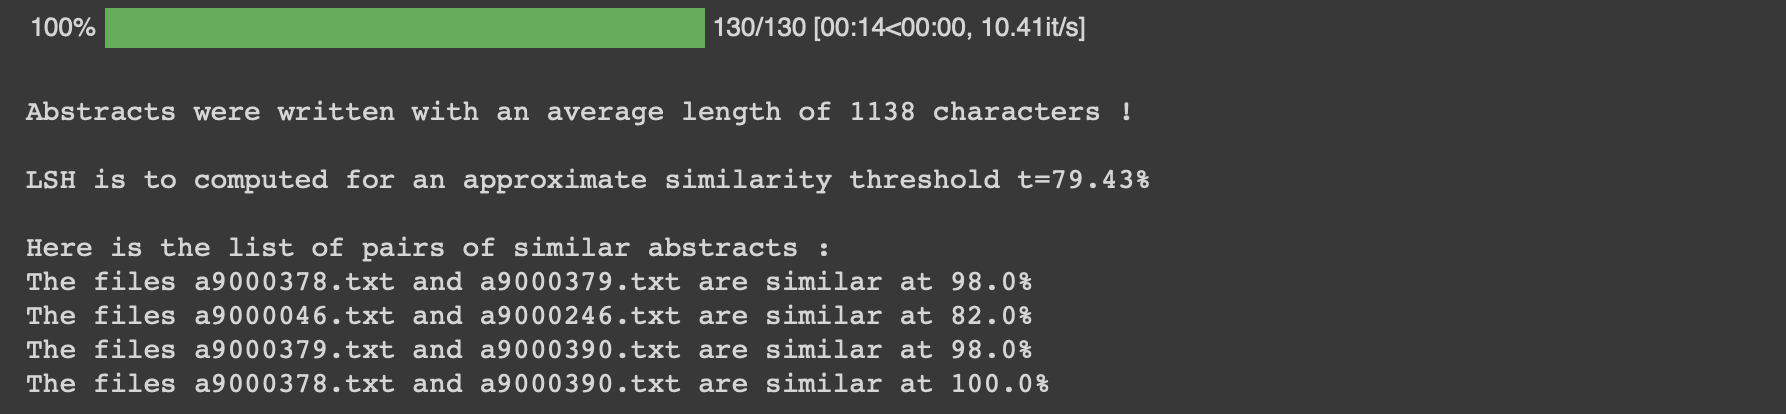


The results above correspond to a test with the first 130 documents in the dataset. As we can see, there were multiple abstracts with a very high similarity. 

Here is the comparison of **a9000046.txt** and **a9000246.txt** which are similar at 82.0% with the differences highlighted.  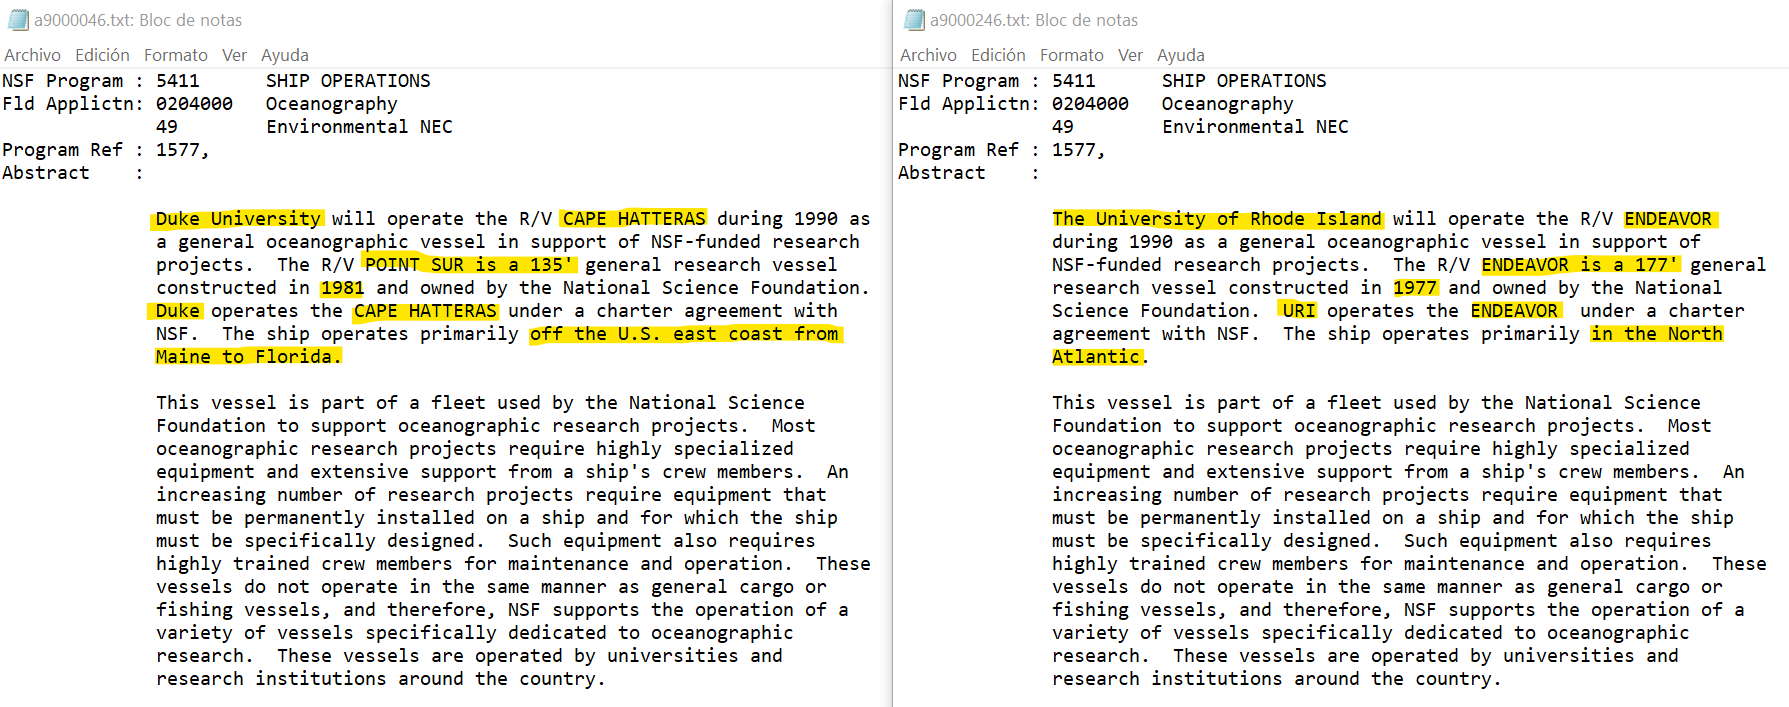

# **Comparision of time performance for Jaccard similarity vs Estimated similarity**


In [ ]:
# Estimation for 2 specific files
doc1 = "a9000046.txt"
doc2 = "a9000246.txt"
text1 = preprocessing(f"{dir_name}/{doc1}")
text2 = preprocessing(f"{dir_name}/{doc2}")

shingles1 = shingler.shingle_list_bytes(text1, shingle_size)
shingles2 = shingler.shingle_list_bytes(text2, shingle_size)

signature1 = minhasher.compute_minhash(shingles1, minhash_length, r_type="array", seed=seed)
signature2 = minhasher.compute_minhash(shingles2, minhash_length, r_type="array", seed=seed)

# jaccard similarity
start_time_jaccard = time.time()
jaccard_similarity = comparer.jaccard_similarity(shingles1, shingles2)
print(f"Jaccard similarity: {round(jaccard_similarity*100,2)}% on {round((time.time() - start_time_jaccard)*1000, 2)} ms" )

# Estimated similarity
start_time_estimated = time.time()
sim, estimated_similarity = comparer.similar_signature(signature1, signature2, similarity_threshold)
print(f"Estimated similarity: {round(float(estimated_similarity)*100,2)}% on {round((time.time() - start_time_estimated)*1000, 2)} ms" )


Jaccard similarity: 79.91% on 0.44 ms
Estimated similarity: 82.0% on 0.34 ms


In [ ]:
# Estimation for random files (to get an average)
number_of_files = len(file_list)
shingle_sets_list = []

for i in tqdm(range(len(file_list))):
    text = preprocessing(f"{dir_name}/{file_list[i]}")  # Get the abstract in one str variable
    # Minhashes the abstract and adds its signature to the matrix
    shingle_sets_list.append(shingler.shingle_list(text, shingle_size))

jaccard_similarity = []
signature_similarity = []

for k in tqdm(range(1000)):
    i, j = np.random.randint(0, number_of_files, 2)
    t0 = time.time()
    comparer.jaccard_similarity(shingle_sets_list[i], shingle_sets_list[j])
    jaccard_similarity.append(time.time() - t0)
    t0 = time.time()
    comparer.signature_similarity(signature_matrix[:,i], signature_matrix[:,j])
    signature_similarity.append(time.time()-t0)
  
print(f"Jaccard similarity takes on average {round(np.mean(jaccard_similarity)*1000, 2)} ms" )
print(f"Estimated similarity takes on average {round(np.mean(signature_similarity)*1000, 2)} ms")

  0%|          | 0/125 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

Jaccard similarity takes on average 0.23 ms
Estimated similarity takes on average 0.25 ms


In [ ]:
set1 = list(np.random.randint(0, 7000, 10000))
set2 = list(np.random.randint(0, 7000, 10000))
t0 = time.time()
comparer.jaccard_similarity(set1, set2)
print(f"Jaccard similarity on 2 simulated bigger texts : {round((time.time() - t0)*1000, 2)}ms ")

Jaccard similarity on 2 simulated bigger texts 3.82ms 


# **Conclusion**

At the beginning it might be surprising to find multiple similar abstracts, but if we look at the details, it seems that those similar correspond to the same project/research but with some little changes (for example same project/research with different universities).

We could also observe that comparing the signatures instead of the whole set of shingles has almost no impact on performance time, but still preserving a good approximation to the real similarity. However if we had found datasets with huge documents, comparing signatures instead of sets of shingles would have a huge positive impact.